<div style="background-color: darkred; padding: 10px; color: white;">

# Soma Proposal Generation 

</div>

<div style="background-color: darkblue; padding: 10px; color: white;">

## Section 1: Proposal Generation in a Single Image Patch

<div style="font-size: 17px;">
    In this section, we provide an overview of the main routines used to generate soma proposals within a single image patch. The proposal generation process follows the algorithm outlined below:
    <br><br>

<pre style="background-color: darkblue; color: white; font-family: monospace;">
    Soma Proposal Generation Algorithm
        1. Detect initial proposals - detect_blobs()
            a. Smooth image with Gaussian filter to reduce false positives.
            b. Laplacian of Gaussian (LoG) to enhance regions where the
               intensity changes dramatically (i.e. higher gradient), then
               apply a non-linear maximum filter.
            c. Generate initial set of proposals by detecting local maximas
    	       that lie outside of the image margins.
            d. Shift each proposal to the brightest voxel in its neighborhood.
               If the brightness is below a threshold, reject the proposal.

        2. Filter proposals - filter_proposals()
            a. Fit Gaussian to neighborhood centered at proposal.
    	    b. Compute closeness of fit by comparing fitted Gaussian and image
               values.
    	    c. Proposals are discarded if (1) fitness is below a threshold or
               (2) standard deviation of Gaussian is out of range.

               
</pre>
</div>
</div>

### Imports


In [1]:
import matplotlib.pyplot as plt
import numpy as np

from random import sample
from skimage.feature import peak_local_max
from scipy.ndimage import gaussian_filter, gaussian_laplace, maximum_filter
from scipy.optimize import curve_fit
from scipy.spatial import KDTree
from time import time
from tifffile import imwrite

from aind_exaspim_soma_detection import soma_proposal_generation as spg
from aind_exaspim_soma_detection.utils import img_util, util

%matplotlib inline


### Subroutines

In [2]:
def detect_blobs(img_patch, bright_threshold, LoG_sigma, margin):
    # Preprocess image
    LoG = gaussian_laplace(
        gaussian_filter(img_patch, sigma=0.5), LoG_sigma
    )

    # Detect local maximas
    peaks = list()
    for peak in peak_local_max(maximum_filter(LoG, 5), min_distance=5):
        peak = tuple([int(x) for x in peak])
        is_inbounds = spg.is_inbounds(img_patch.shape, peak, margin)
        if LoG[peak] > 0 and is_inbounds:
            peaks.append(peak)
    return spg.shift_to_brightest(img_patch, peaks, bright_threshold), LoG


def filter_proposals(img_patch, proposals, radius=5):
    # Main
    filtered_proposals = list()
    discared_proposals = list()
    for proposal in proposals:
        # Fit Gaussian
        proposal = tuple(map(int, proposal))
        fit, params = spg.gaussian_fitness(img_patch, proposal, radius)
        mean, std = params[0:3], params[3:6]

        # Check whether to filter
        feasible_range = all(std > 0.4) and all(std < 10)
        if fit > 0.8 and (feasible_range and np.mean(std) > 0.65):
            print("Accept:", img_patch[proposal], fit, std, np.mean(std))
            proposal = [proposal[i] + mean[i] - radius for i in range(3)]
            filtered_proposals.append(proposal)
        else:
            print("Reject:", img_patch[proposal], fit, std, np.mean(std))
            discared_proposals.append(proposal)
    return filtered_proposals, discared_proposals


def get_detections_img(shape, voxels):
    detections_img = np.zeros(shape)
    for voxel in voxels:
        voxel = tuple([int(v) for v in voxel])
        detections_img = img_util.mark_voxel(detections_img, voxel)
    return detections_img


### Initializations

In [3]:
# Parameters
bucket_name = "aind-open-data"
brain_id = "719654"
multiscale = 4

bright_threshold = 1
LoG_sigma = 5
d = 16  # image margin

# Open img
prefix_lookup = util.read_json("/root/capsule/data/exaspim_image_prefixes.json")
img = img_util.open_img(prefix_lookup[brain_id] + str(multiscale))
print("Image Shape:", img.shape)


Image Shape: (1, 1, 1799, 1796, 3893)


### Main

Accept: 4050 0.8849263233914128 [1.56386215 1.2593719  1.56858278] 1.463938945139051

# Proposals: 1
# Rejects: 0
Runtime: 0.10084128379821777


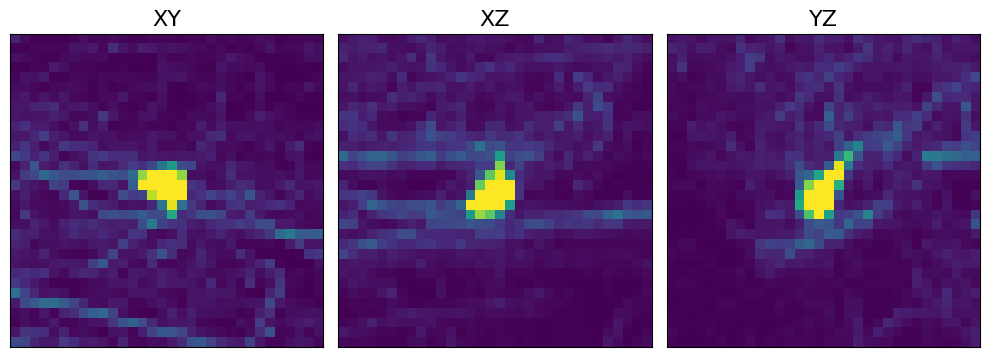

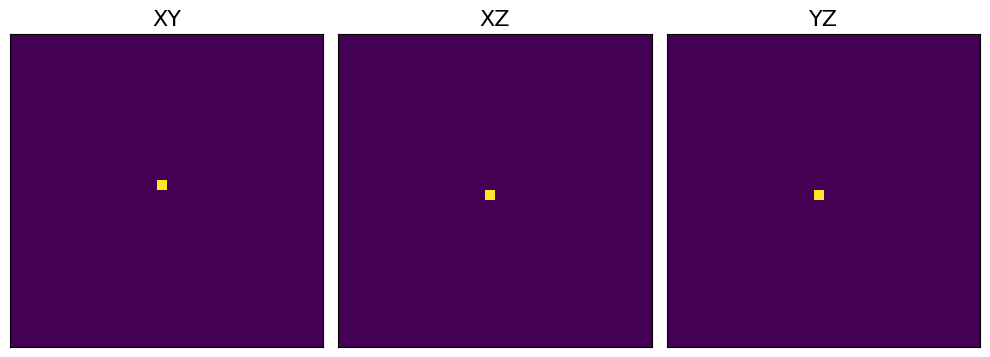

/root/capsule/code/aind-exaspim-soma-detection/src/aind_exaspim_soma_detection/utils/img_util.py:155: RuntimeWarning: invalid value encountered in divide
  img = (2**16 - 1) * (img / np.max(img))
/root/capsule/code/aind-exaspim-soma-detection/src/aind_exaspim_soma_detection/utils/img_util.py:156: RuntimeWarning: invalid value encountered in cast
  return (img).astype(np.uint16)


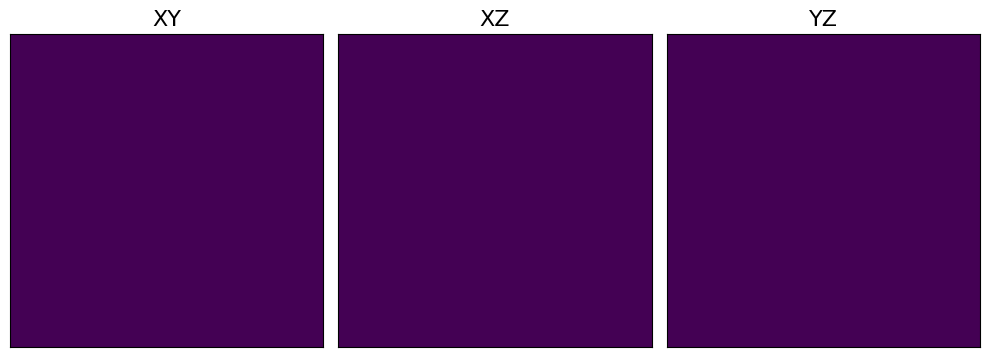

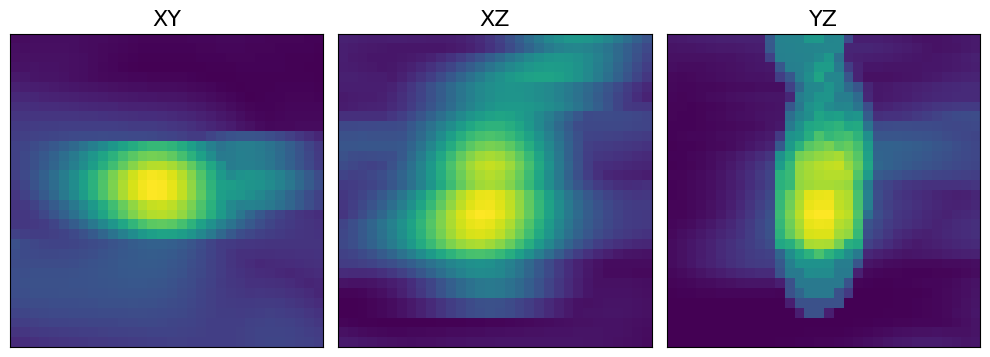

In [4]:
# Region of interest
xyz = [10331.349,14920.623,10028.0]
shape = [64, 64, 64]

# Read image patch
voxel = img_util.to_voxels(xyz, multiscale=multiscale)
img_patch = spg.get_patch(img, voxel, shape, from_center=True)

# Proposal generation
t0 = time()
proposals, LoG_img_patch = detect_blobs(img_patch, bright_threshold, LoG_sigma, d)
proposals, rejects = filter_proposals(img_patch, proposals, radius=5)

print("\n# Proposals:", len(proposals))
print("# Rejects:", len(rejects))
print("Runtime:", time() - t0)

# Visualize Results
proposals_img = get_detections_img(img_patch.shape, proposals)
rejects_img = get_detections_img(img_patch.shape, rejects)

img_util.plot_mips(img_patch[d:-d, d:-d, d:-d], clip_bool=True)
img_util.plot_mips(proposals_img[d:-d, d:-d, d:-d])
img_util.plot_mips(rejects_img[d:-d, d:-d, d:-d])
img_util.plot_mips(LoG_img_patch[d:-d, d:-d, d:-d])

# Save Results
#imwrite("img_patch.tiff", img_patch[d:-d, d:-d, d:-d])
#imwrite("proposals.tiff", proposals_img[d:-d, d:-d, d:-d])
#imwrite("rejects.tiff", rejects_img[d:-d, d:-d, d:-d])

### Visualize Gaussian Fit

Fitness Score: 0.8855805429178072
Parameters: [5.59314302e+00 5.50537510e+00 5.79365731e+00 1.56933269e+00
 1.26259615e+00 1.57242499e+00 4.91531689e+03 1.33486868e+02]


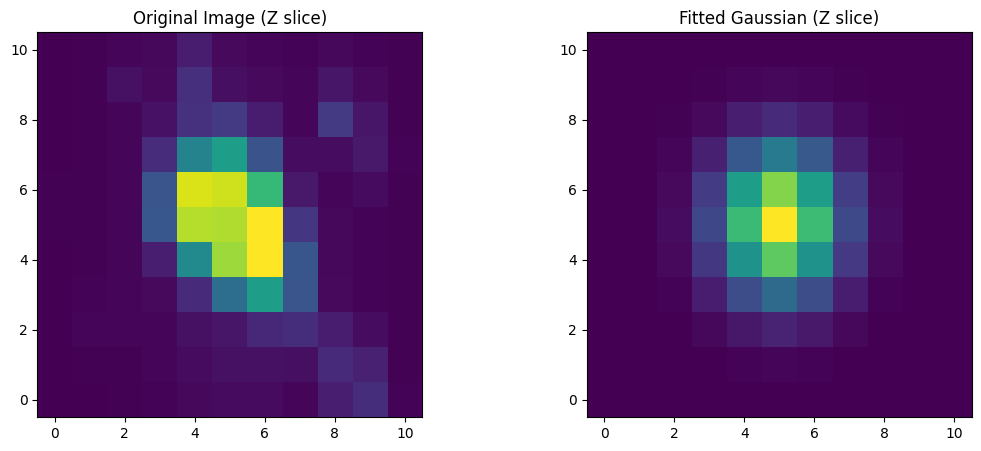

In [5]:
# Parameters
margin = 16
radius = 5

# Get valid center
while True:
    center = sample(proposals + rejects, 1)[0]
    if spg.is_inbounds(img_patch.shape, center, margin=margin):
        break

# Get patch from img
x0, y0, z0 = tuple(map(int, center))
x_min, x_max = max(0, x0 - radius), min(img_patch.shape[0], x0 + radius + 1)
y_min, y_max = max(0, y0 - radius), min(img_patch.shape[1], y0 + radius + 1)
z_min, z_max = max(0, z0 - radius), min(img_patch.shape[2], z0 + radius + 1)
subpatch = img_patch[x_min:x_max, y_min:y_max, z_min:z_max]
img_vals = subpatch.ravel()

# Generate coordinates
xyz = [np.linspace(0, subpatch.shape[i], subpatch.shape[i]) for i in range(3)]
x, y, z = np.meshgrid(xyz[0], xyz[1], xyz[2], indexing='ij')
xyz = (x.ravel(), y.ravel(), z.ravel())

# Fit Gaussian
try:
    shape = subpatch.shape
    x0, y0, z0 = shape[0] // 2, shape[1] // 2, shape[2] // 2
    p0 = (x0, y0, z0, 2, 2, 2, np.max(subpatch), np.min(subpatch))
    params, _ = curve_fit(spg.gaussian_3d, xyz, img_vals, p0=p0)
except RuntimeError:
    pass

# Fitness quality
fitness_score = spg.fitness_quality(subpatch, xyz, params)
print("Fitness Score:", fitness_score)
print("Parameters:", params)

# Visualize image patch
fig, axs = plt.subplots(1, 2, figsize=(13, 5))
axs[0].imshow(subpatch[:, :, z0], cmap='viridis', origin='lower')
axs[0].set_title("Original Image (Z slice)")

# Visualize fitted gaussian
if params is not None:
    fitted_blob = spg.gaussian_3d((x, y, z), *params).reshape(x.shape)
    axs[1].imshow(fitted_blob[:, :, z0], cmap='viridis', origin='lower')
    axs[1].set_title("Fitted Gaussian (Z slice)")


In [6]:
stop

NameError: name 'stop' is not defined

<div style="background-color: darkblue; padding: 10px; color: white;">

## Section 2: Proposal Generation in Whole Brain

<div style="font-size: 17px;">
    In this section, we provide an overview of the main routines used to generate soma proposals on the scale of a whole brain.

</div>

### Imports

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

### Main

In [ ]:
# Parameters
margin = 16
overlap = (36, 36, 36)
patch_shape = (128, 128, 128)

bright_threshold = 200
LoG_sigma = 6
save_results = False

# Initializations
output_dir = "/root/capsule/results/soma_proposals"
offsets = img_util.sliding_window_coords_3d(img, patch_shape, overlap)
print("# Image Patches:", len(offsets))

# Proposal generation
t0 = time()
with ThreadPoolExecutor() as executor:
    # Assign threads
    threads = list()
    for offset in offsets[0:1000]:
        threads.append(
            executor.submit(
                spg.generate_proposals,
                img,
                offset,
                margin,
                patch_shape,
                multiscale,
                bright_threshold,
                LoG_sigma,
            )
        )

    # Process results
    proposals = list()
    pbar = tqdm(total=len(threads))
    for thread in as_completed(threads):
        proposals.extend(thread.result())
        pbar.update(1)

# Global filtering
proposals = spg.global_filtering(proposals)
print("# Proposals Generated:", len(proposals))
print("Runtime:", time() - t0)

# Save results (if applicable)
if save_results:
    util.mkdir(output_dir, delete=True)
    util.write_points(output_dir, proposals, color="0.0 0.0 1.0", prefix="proposal_")